In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, Subtract
from tensorflow.keras.models import Model
from Environment import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
'''
Direction mapping:
0: left = [-1, 0]
1: right = [1, 0]
2: up = [0, -1]
3: down = [0, 1]
'''

class User_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (4,))    #curr_x, curr_y, target_x, target_y
        x = Subtract()([input_A[:, 2:], input_A[:, :2]])
        x = Dense(32, activation = 'relu')(x)
        x = Dense(64, activation = 'relu')(x)
        x = Dense(32, activation = 'relu')(x)
        x = Dense(4)(x) #left, right, down, up
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 0.75
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(4)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])
            

    def play_one_step(self, env, state, mod_agent, mod_state):
        action_user = self.exp_policy(state)
        action_user_one_hot = make_one_hot(action_user, 4)
        curr_loc = state[:2]
        target_loc = state[2:]
        action_user_one_hot.extend(curr_loc)
        mod_curr_state = action_user_one_hot[:]
        mod_curr_state = np.array(mod_curr_state)
        mod_state.append(mod_curr_state)
        new_loc, reward, done, mod_reward = mod_agent.play_one_step(env, mod_state, curr_loc, target_loc, self)
        next_state = [new_loc[0], new_loc[1], target_loc[0], target_loc[1]]
        self.replay_buffer.append(state, action_user, reward, next_state, done)
        
        return next_state, reward, done, mod_reward
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [3]:
prev_timesteps = 4

class Mod_Agent:
    def __init__(self):
        #model
        #-----------------------------------------------------
        input_A = Input(shape = (None,6))    #dir_one_hot, curr_x, curr_y
        x = LSTM(16, return_sequences = True)(input_A)
        x = LSTM(32, return_sequences = True)(x)
        x = LSTM(16)(x)
        x = Dense(4)(x)
        
        self.model = Model(inputs = input_A, outputs = x)
        print(self.model.summary())
        #---------------------------------------------------
        
        self.target_model = tf.keras.models.clone_model(self.model)
        self.target_model.set_weights(self.model.get_weights())
        
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
        self.batch_size = 128
        self.replay_buffer_size = 1024
        self.replay_buffer = Replay_Buffer(self.replay_buffer_size)
        self.epsilon = 0.75
        self.gamma = 0.9
        
    def exp_policy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(1,5)
        else:
            state = np.array(state)[np.newaxis]
            Q_values = self.model(state)
            return np.argmax(Q_values[0])+1
        
    def play_one_step(self, env, state, curr_loc, target_loc, user_agent):
        #Agent not aware of target location
        state = np.array(state)
        if state.shape[0]<4:
            short = 4-state.shape[0]
            array = np.array([[0, 0, 0, 0, -1, -1] for i in range(short)])
            state = np.concatenate((array, state))
            assert(state.shape[0]==4)
        state = state.tolist()
        
            
        state_temp = np.array(state)[-4:]
        action_mod = self.exp_policy(state_temp)
#         print(action_mod)
        action_user = np.argmax(state[-1][:4])
        new_loc, reward_user, reward_mod, done = env.step(action_user, action_mod, target_loc, curr_loc)
        next_dir = user_agent.exp_policy(np.array([new_loc[0], new_loc[1], target_loc[0], target_loc[1]]))
        
        next_dir_one_hot = make_one_hot(next_dir, 4)
        next_dir_one_hot.extend(new_loc)
        temp_next_state = next_dir_one_hot[:]
        temp_next_state = np.array(temp_next_state)
        next_state = deepcopy(state)
        next_state.append(temp_next_state)
        
        next_state = np.array(next_state)[-4:]
        state = np.array(state)[-4:]
        
        if next_state.shape[0]<4:
            short = 4-next_state.shape[0]
            array = np.array([[0, 0, 0, 0, -1, -1] for i in range(short)])
            next_state = np.concatenate((next_state, array))
            assert(next_state.shape[0]==4)
            
        
            
        self.replay_buffer.append(state, action_mod-1, reward_mod, next_state, done)

        
        return new_loc, reward_user, done, reward_mod
    
    def sample_experience(self):
        indices = np.random.randint(len(self.replay_buffer.state_history), size = self.batch_size)
        
        states = np.array([self.replay_buffer.state_history[i] for i in indices])
        actions = np.array([self.replay_buffer.action_history[i] for i in indices])
        next_states = np.array([self.replay_buffer.next_state_history[i] for i in indices])
        rewards = np.array([self.replay_buffer.rewards_history[i] for i in indices])
        dones = np.array([self.replay_buffer.done_history[i] for i in indices])
        
        return states, actions, next_states, rewards, dones
    
    def train(self):
        states, actions, next_states, rewards, dones = self.sample_experience()
        next_Q_values = self.model(next_states)
        best_next_actions = np.argmax(next_Q_values, axis= 1)
        next_mask = tf.one_hot(best_next_actions, 4).numpy()
        max_next_Q_values = tf.reduce_sum(self.target_model(next_states)*next_mask, axis = 1, keepdims = True)
        target_Q_values = rewards + (1-dones)*self.gamma*max_next_Q_values
        
        mask = tf.one_hot(actions, 4)
        
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values*mask, axis = 1, keepdims = True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

In [4]:
env = Environment()
env.cells = np.array([[0.7, 0.1], [0.1, 0.1], [0.5, 0.7], [0.6, 0.2], [0.7, 0.4], [0.2, 0.9]])

user_agent = User_Agent()
mod_agent = Mod_Agent()

Icon Locations:
[[0.  0.7]
 [0.6 0.8]
 [0.9 0.3]
 [0.  0.3]
 [0.6 0.9]
 [0.7 0. ]]
Icon usage Probabilities
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, 2)]          0           input_1[0][0]                    
__________________________________________________________________________________________________
subtract (

  0%|▏                                                                           | 101/50000 [00:20<3:26:43,  4.02it/s]

Updated Weights
Mean Reward = -34.48514851485149
26
Saved Weights


  0%|▎                                                                           | 201/50000 [00:43<3:18:24,  4.18it/s]

Updated Weights
Mean Reward = -36.87
14


  1%|▍                                                                           | 301/50000 [01:04<2:39:30,  5.19it/s]

Updated Weights
Mean Reward = -34.13
24


  1%|▌                                                                           | 402/50000 [01:26<2:19:16,  5.94it/s]

Updated Weights
Mean Reward = -35.92
21


  1%|▊                                                                           | 500/50000 [01:47<2:34:34,  5.34it/s]

Updated Weights
Mean Reward = -36.39
17


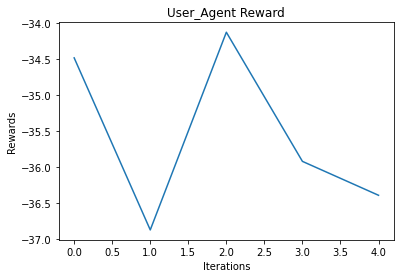

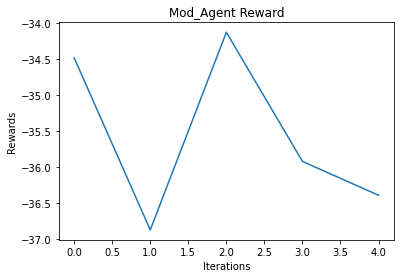

  1%|▉                                                                           | 601/50000 [02:07<2:34:46,  5.32it/s]

Updated Weights
Mean Reward = -36.18
15


  1%|█                                                                           | 702/50000 [02:26<2:39:56,  5.14it/s]

Updated Weights
Mean Reward = -35.25
18


  2%|█▏                                                                          | 801/50000 [02:45<2:20:31,  5.84it/s]

Updated Weights
Mean Reward = -34.85
26


  2%|█▎                                                                          | 901/50000 [03:04<2:51:06,  4.78it/s]

Updated Weights
Mean Reward = -31.88
34
Saved Weights


  2%|█▌                                                                         | 1000/50000 [03:22<2:37:12,  5.19it/s]

Updated Weights
Mean Reward = -33.12
33


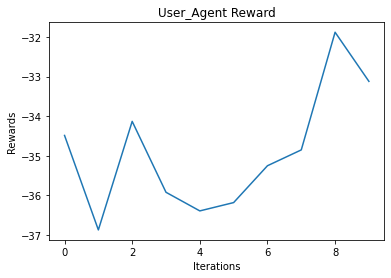

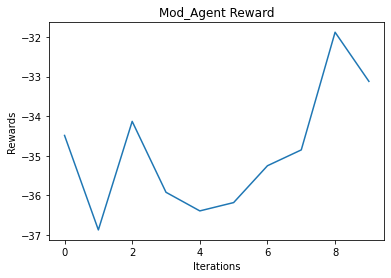

  2%|█▋                                                                         | 1101/50000 [03:42<2:48:34,  4.83it/s]

Updated Weights
Mean Reward = -27.7
55
Saved Weights


  2%|█▊                                                                         | 1201/50000 [04:01<2:59:33,  4.53it/s]

Updated Weights
Mean Reward = -26.21
57
Saved Weights


  3%|█▉                                                                         | 1301/50000 [04:19<2:05:26,  6.47it/s]

Updated Weights
Mean Reward = -27.55
53


  3%|██                                                                         | 1401/50000 [04:39<2:48:12,  4.82it/s]

Updated Weights
Mean Reward = -29.03
52


  3%|██▎                                                                        | 1500/50000 [04:59<2:50:38,  4.74it/s]

Updated Weights
Mean Reward = -29.34
52


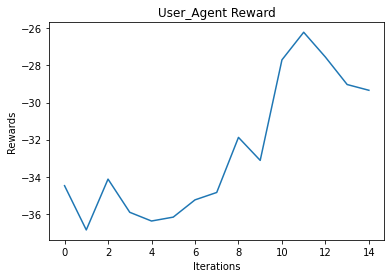

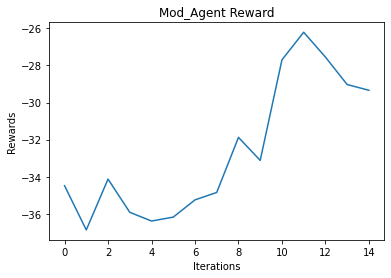

  3%|██▍                                                                        | 1601/50000 [05:18<2:52:24,  4.68it/s]

Updated Weights
Mean Reward = -27.64
57


  3%|██▌                                                                        | 1701/50000 [05:38<2:39:39,  5.04it/s]

Updated Weights
Mean Reward = -28.06
55


  4%|██▋                                                                        | 1802/50000 [05:57<2:23:50,  5.58it/s]

Updated Weights
Mean Reward = -27.43
54


  4%|██▊                                                                        | 1901/50000 [06:17<2:59:47,  4.46it/s]

Updated Weights
Mean Reward = -27.27
58
Saved Weights


  4%|██▉                                                                        | 1999/50000 [06:36<3:21:44,  3.97it/s]

Updated Weights
Mean Reward = -28.52
47


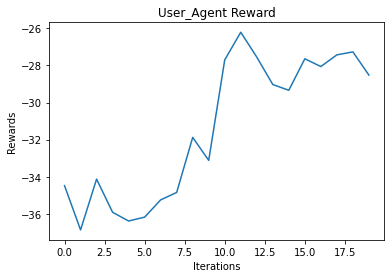

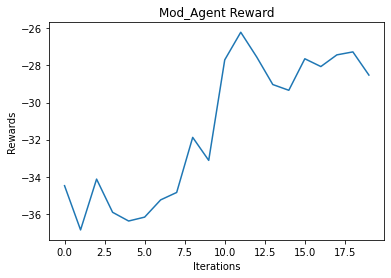

  4%|███▏                                                                       | 2101/50000 [06:58<2:58:52,  4.46it/s]

Updated Weights
Mean Reward = -27.04
64
Saved Weights


  4%|███▎                                                                       | 2201/50000 [07:20<2:50:29,  4.67it/s]

Updated Weights
Mean Reward = -28.32
56


  5%|███▍                                                                       | 2300/50000 [07:40<3:24:34,  3.89it/s]

Updated Weights
Mean Reward = -25.67
64


  5%|███▌                                                                       | 2401/50000 [08:01<2:40:58,  4.93it/s]

Updated Weights
Mean Reward = -26.03
59


  5%|███▊                                                                       | 2500/50000 [08:22<3:15:15,  4.05it/s]

Updated Weights
Mean Reward = -27.24
58


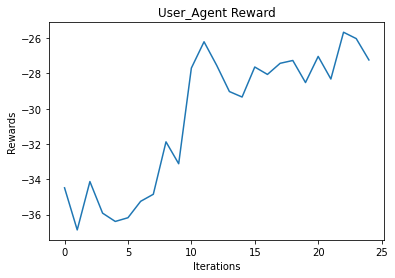

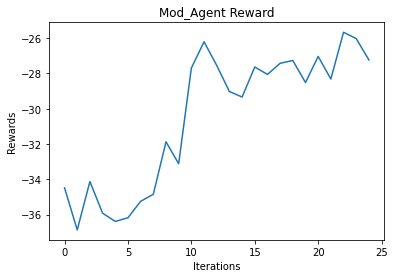

  5%|███▉                                                                       | 2601/50000 [08:42<3:02:15,  4.33it/s]

Updated Weights
Mean Reward = -23.84
73
Saved Weights


  5%|████                                                                       | 2701/50000 [09:02<2:47:27,  4.71it/s]

Updated Weights
Mean Reward = -25.98
62


  6%|████▏                                                                      | 2802/50000 [09:25<2:38:58,  4.95it/s]

Updated Weights
Mean Reward = -30.16
41


  6%|████▎                                                                      | 2901/50000 [09:48<3:20:13,  3.92it/s]

Updated Weights
Mean Reward = -25.13
62


  6%|████▌                                                                      | 3000/50000 [10:15<3:27:35,  3.77it/s]

Updated Weights
Mean Reward = -29.09
51


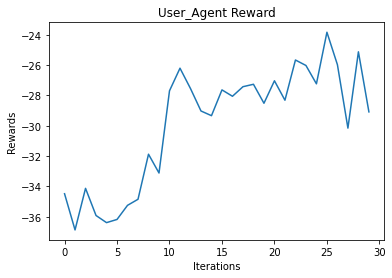

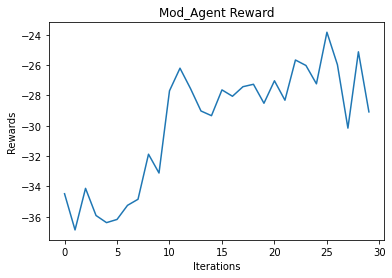

  6%|████▋                                                                      | 3101/50000 [10:47<4:17:24,  3.04it/s]

Updated Weights
Mean Reward = -30.47
45


  6%|████▊                                                                      | 3201/50000 [11:17<3:53:20,  3.34it/s]

Updated Weights
Mean Reward = -28.89
48


  7%|████▉                                                                      | 3302/50000 [11:46<2:49:36,  4.59it/s]

Updated Weights
Mean Reward = -27.48
52


  7%|█████                                                                      | 3401/50000 [12:16<3:46:15,  3.43it/s]

Updated Weights
Mean Reward = -27.92
55


  7%|█████▎                                                                     | 3500/50000 [12:48<4:32:16,  2.85it/s]

Updated Weights
Mean Reward = -31.39
36


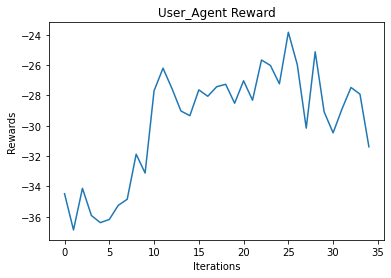

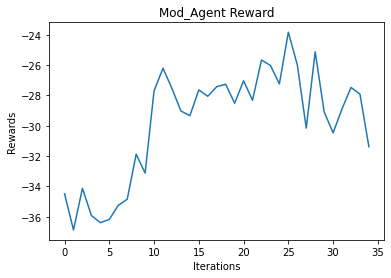

  7%|█████▍                                                                     | 3601/50000 [13:22<4:51:26,  2.65it/s]

Updated Weights
Mean Reward = -33.34
29


  7%|█████▌                                                                     | 3701/50000 [13:51<3:17:52,  3.90it/s]

Updated Weights
Mean Reward = -31.95
34


  8%|█████▋                                                                     | 3802/50000 [14:18<3:05:37,  4.15it/s]

Updated Weights
Mean Reward = -32.09
35


  8%|█████▊                                                                     | 3901/50000 [14:46<3:49:52,  3.34it/s]

Updated Weights
Mean Reward = -33.95
26


  8%|██████                                                                     | 4000/50000 [15:11<3:35:08,  3.56it/s]

Updated Weights
Mean Reward = -30.89
45


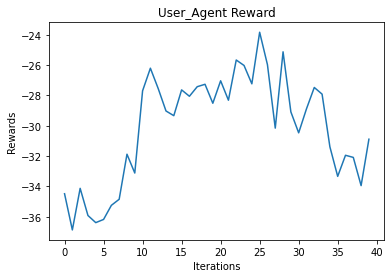

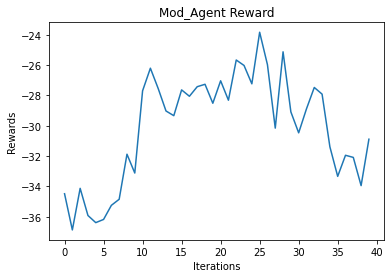

  8%|██████▏                                                                    | 4101/50000 [15:42<4:14:45,  3.00it/s]

Updated Weights
Mean Reward = -34.11
27


  8%|██████▎                                                                    | 4201/50000 [16:12<4:34:47,  2.78it/s]

Updated Weights
Mean Reward = -33.84
28


  9%|██████▍                                                                    | 4301/50000 [16:42<3:30:25,  3.62it/s]

Updated Weights
Mean Reward = -34.5
23


  9%|██████▌                                                                    | 4401/50000 [17:11<3:07:40,  4.05it/s]

Updated Weights
Mean Reward = -32.07
33


  9%|██████▊                                                                    | 4500/50000 [17:41<4:09:46,  3.04it/s]

Updated Weights
Mean Reward = -34.93
24


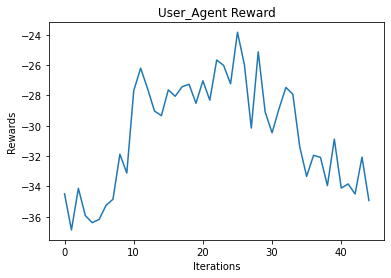

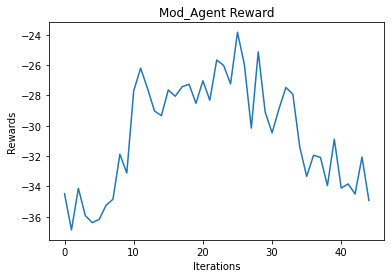

  9%|██████▉                                                                    | 4601/50000 [18:11<3:50:15,  3.29it/s]

Updated Weights
Mean Reward = -32.22
29


  9%|███████                                                                    | 4701/50000 [18:42<3:58:36,  3.16it/s]

Updated Weights
Mean Reward = -33.92
25


 10%|███████▏                                                                   | 4801/50000 [19:11<4:01:48,  3.12it/s]

Updated Weights
Mean Reward = -34.09
28


 10%|███████▎                                                                   | 4902/50000 [19:42<2:42:56,  4.61it/s]

Updated Weights
Mean Reward = -33.02
32


 10%|███████▌                                                                   | 5000/50000 [20:14<4:34:00,  2.74it/s]

Updated Weights
Mean Reward = -31.96
37


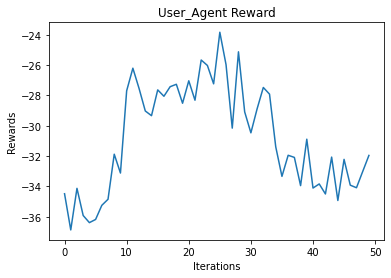

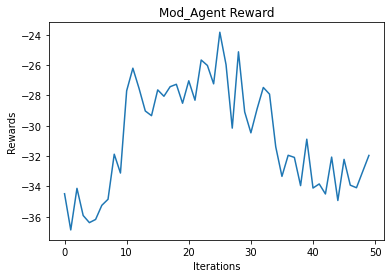

 10%|███████▋                                                                   | 5101/50000 [20:49<4:37:44,  2.69it/s]

Updated Weights
Mean Reward = -34.87
25


 10%|███████▊                                                                   | 5201/50000 [21:26<4:36:26,  2.70it/s]

Updated Weights
Mean Reward = -35.95
17


 11%|███████▉                                                                   | 5301/50000 [22:01<3:56:33,  3.15it/s]

Updated Weights
Mean Reward = -35.76
19


 11%|████████                                                                   | 5401/50000 [22:36<3:59:40,  3.10it/s]

Updated Weights
Mean Reward = -36.98
14


 11%|████████▎                                                                  | 5500/50000 [23:11<4:06:03,  3.01it/s]

Updated Weights
Mean Reward = -36.71
15


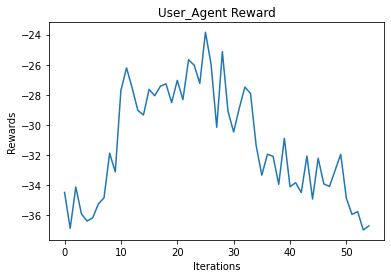

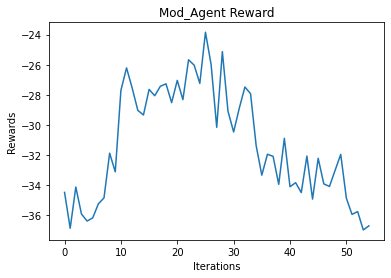

 11%|████████▍                                                                  | 5601/50000 [23:46<4:24:42,  2.80it/s]

Updated Weights
Mean Reward = -36.83
15


 11%|████████▌                                                                  | 5701/50000 [24:20<3:55:02,  3.14it/s]

Updated Weights
Mean Reward = -37.33
14


 12%|████████▋                                                                  | 5801/50000 [24:54<4:31:13,  2.72it/s]

Updated Weights
Mean Reward = -35.74
17


 12%|████████▊                                                                  | 5901/50000 [25:27<3:28:58,  3.52it/s]

Updated Weights
Mean Reward = -35.84
18


 12%|█████████                                                                  | 6000/50000 [26:00<4:17:04,  2.85it/s]

Updated Weights
Mean Reward = -34.73
18


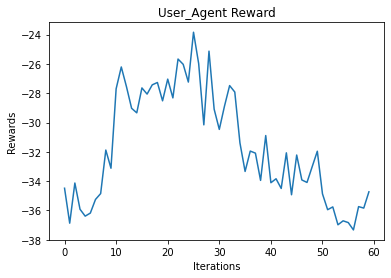

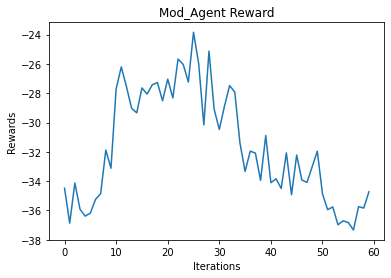

 12%|█████████▏                                                                 | 6101/50000 [26:38<3:33:26,  3.43it/s]

Updated Weights
Mean Reward = -37.29
10


 12%|█████████▎                                                                 | 6201/50000 [27:16<3:39:18,  3.33it/s]

Updated Weights
Mean Reward = -37.36
9


 13%|█████████▍                                                                 | 6301/50000 [27:54<5:03:46,  2.40it/s]

Updated Weights
Mean Reward = -35.73
18


 13%|█████████▌                                                                 | 6401/50000 [28:32<4:36:05,  2.63it/s]

Updated Weights
Mean Reward = -37.64
14


 13%|█████████▊                                                                 | 6500/50000 [29:07<3:38:16,  3.32it/s]

Updated Weights
Mean Reward = -36.23
14


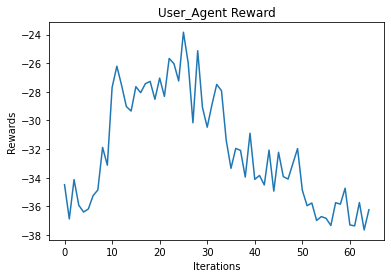

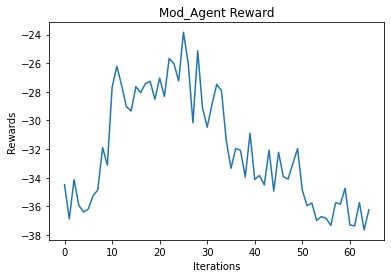

 13%|█████████▉                                                                 | 6601/50000 [29:46<4:46:03,  2.53it/s]

Updated Weights
Mean Reward = -35.68
17


 13%|██████████                                                                 | 6701/50000 [30:24<4:40:33,  2.57it/s]

Updated Weights
Mean Reward = -37.53
10


 14%|██████████▏                                                                | 6801/50000 [30:58<4:42:16,  2.55it/s]

Updated Weights
Mean Reward = -34.44
23


 14%|██████████▎                                                                | 6901/50000 [31:33<3:45:53,  3.18it/s]

Updated Weights
Mean Reward = -34.28
22


 14%|██████████▌                                                                | 7000/50000 [32:10<3:54:35,  3.06it/s]

Updated Weights
Mean Reward = -36.85
13


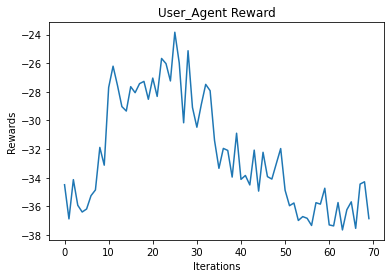

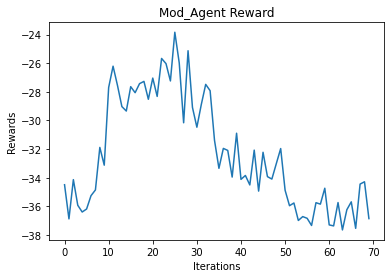

 14%|██████████▋                                                                | 7100/50000 [32:49<4:47:21,  2.49it/s]

Updated Weights
Mean Reward = -37.58
12


 14%|██████████▊                                                                | 7201/50000 [33:28<5:03:57,  2.35it/s]

Updated Weights
Mean Reward = -37.46
9


 15%|██████████▉                                                                | 7301/50000 [34:07<4:39:44,  2.54it/s]

Updated Weights
Mean Reward = -36.52
14


 15%|███████████                                                                | 7401/50000 [34:45<4:39:21,  2.54it/s]

Updated Weights
Mean Reward = -37.15
9


 15%|███████████▎                                                               | 7500/50000 [35:23<3:59:09,  2.96it/s]

Updated Weights
Mean Reward = -36.56
12


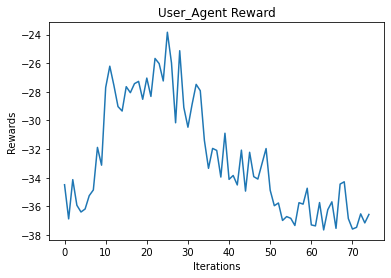

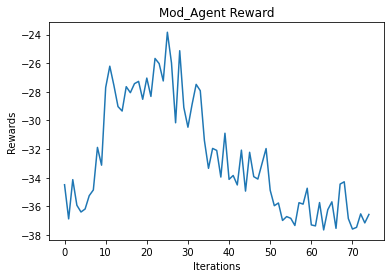

 15%|███████████▍                                                               | 7601/50000 [36:02<4:26:19,  2.65it/s]

Updated Weights
Mean Reward = -36.8
16


 15%|███████████▌                                                               | 7701/50000 [36:41<4:48:36,  2.44it/s]

Updated Weights
Mean Reward = -37.64
10


 16%|███████████▋                                                               | 7801/50000 [37:21<4:47:05,  2.45it/s]

Updated Weights
Mean Reward = -38.75
8


 16%|███████████▊                                                               | 7901/50000 [38:00<4:52:00,  2.40it/s]

Updated Weights
Mean Reward = -36.25
15


 16%|████████████                                                               | 8000/50000 [38:43<4:59:26,  2.34it/s]

Updated Weights
Mean Reward = -37.42
9


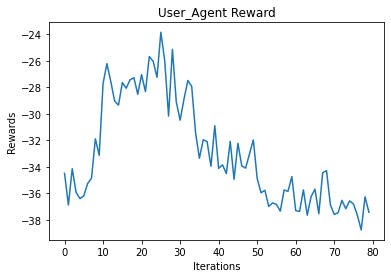

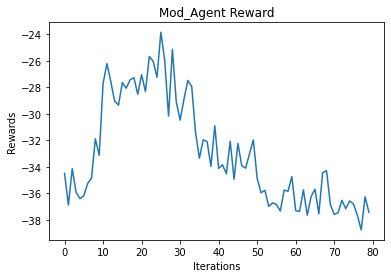

 16%|████████████▏                                                              | 8101/50000 [39:25<5:08:46,  2.26it/s]

Updated Weights
Mean Reward = -37.47
10


 16%|████████████▎                                                              | 8201/50000 [40:07<4:47:43,  2.42it/s]

Updated Weights
Mean Reward = -39.29
4


 17%|████████████▍                                                              | 8301/50000 [40:48<4:51:41,  2.38it/s]

Updated Weights
Mean Reward = -37.4
10


 17%|████████████▌                                                              | 8401/50000 [41:28<5:06:42,  2.26it/s]

Updated Weights
Mean Reward = -36.83
11


 17%|████████████▊                                                              | 8500/50000 [42:09<4:42:19,  2.45it/s]

Updated Weights
Mean Reward = -37.41
10


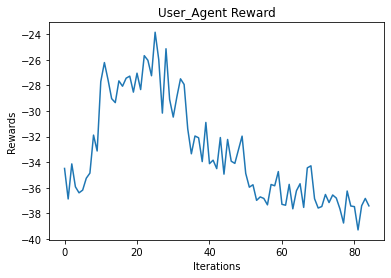

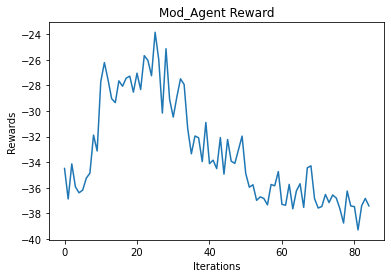

 17%|████████████▉                                                              | 8601/50000 [42:51<4:57:55,  2.32it/s]

Updated Weights
Mean Reward = -38.2
6


 17%|█████████████                                                              | 8701/50000 [43:33<4:57:37,  2.31it/s]

Updated Weights
Mean Reward = -39.39
5


 18%|█████████████▏                                                             | 8801/50000 [44:13<4:48:31,  2.38it/s]

Updated Weights
Mean Reward = -36.4
13


 18%|█████████████▎                                                             | 8901/50000 [44:54<4:53:32,  2.33it/s]

Updated Weights
Mean Reward = -38.86
6


 18%|█████████████▌                                                             | 9000/50000 [45:37<4:55:55,  2.31it/s]

Updated Weights
Mean Reward = -39.17
4


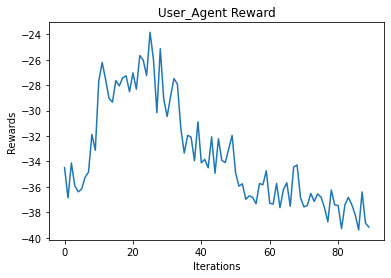

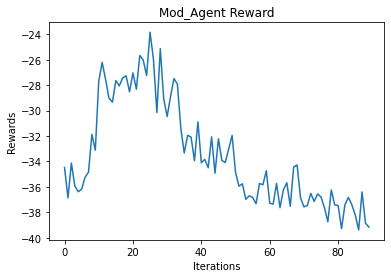

 18%|█████████████▋                                                             | 9101/50000 [46:21<4:24:49,  2.57it/s]

Updated Weights
Mean Reward = -38.18
8


 18%|█████████████▊                                                             | 9201/50000 [47:03<4:57:04,  2.29it/s]

Updated Weights
Mean Reward = -37.78
8


 19%|█████████████▉                                                             | 9301/50000 [47:46<4:10:30,  2.71it/s]

Updated Weights
Mean Reward = -38.68
4


 19%|██████████████                                                             | 9401/50000 [48:29<5:02:29,  2.24it/s]

Updated Weights
Mean Reward = -38.17
8


 19%|██████████████▎                                                            | 9500/50000 [49:12<5:10:14,  2.18it/s]

Updated Weights
Mean Reward = -38.57
5


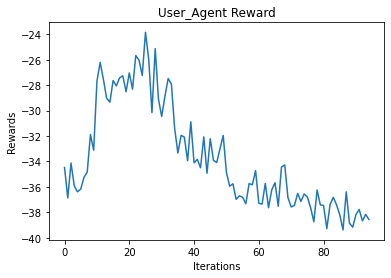

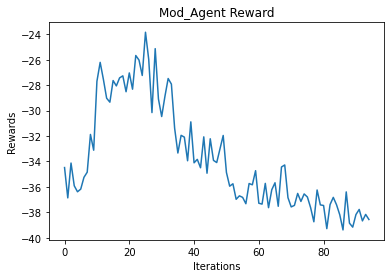

 19%|██████████████▍                                                            | 9601/50000 [49:56<4:41:31,  2.39it/s]

Updated Weights
Mean Reward = -38.13
11


 19%|██████████████▌                                                            | 9701/50000 [50:39<4:29:35,  2.49it/s]

Updated Weights
Mean Reward = -38.82
6


 20%|██████████████▋                                                            | 9801/50000 [51:22<4:15:03,  2.63it/s]

Updated Weights
Mean Reward = -37.8
8


 20%|██████████████▊                                                            | 9901/50000 [52:05<4:54:12,  2.27it/s]

Updated Weights
Mean Reward = -38.87
5


 20%|██████████████▊                                                           | 10000/50000 [52:46<4:54:24,  2.26it/s]

Updated Weights
Mean Reward = -37.67
7


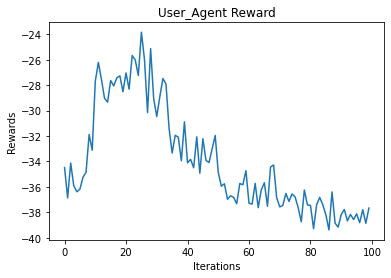

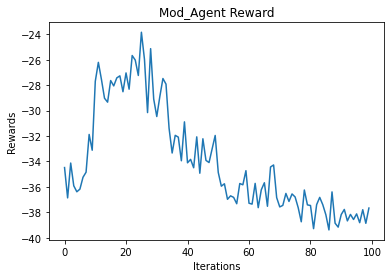

 20%|██████████████▉                                                           | 10101/50000 [53:31<4:36:39,  2.40it/s]

Updated Weights
Mean Reward = -37.86
7


 20%|███████████████                                                           | 10201/50000 [54:16<4:54:36,  2.25it/s]

Updated Weights
Mean Reward = -38.47
7


 21%|███████████████▏                                                          | 10301/50000 [55:00<4:55:48,  2.24it/s]

Updated Weights
Mean Reward = -38.26
6


 21%|███████████████▍                                                          | 10401/50000 [55:45<5:08:07,  2.14it/s]

Updated Weights
Mean Reward = -38.92
4


 21%|███████████████▌                                                          | 10500/50000 [56:29<5:03:09,  2.17it/s]

Updated Weights
Mean Reward = -38.41
5


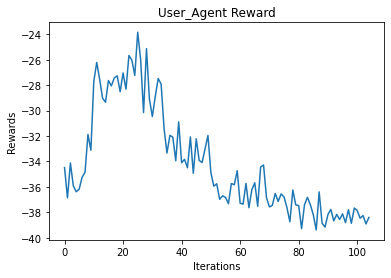

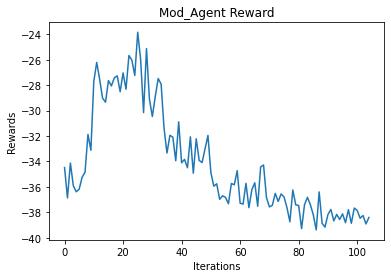

 21%|███████████████▋                                                          | 10601/50000 [57:14<4:53:20,  2.24it/s]

Updated Weights
Mean Reward = -38.59
7


 21%|███████████████▊                                                          | 10701/50000 [57:59<5:12:35,  2.10it/s]

Updated Weights
Mean Reward = -39.02
4


 22%|███████████████▉                                                          | 10801/50000 [58:44<4:02:03,  2.70it/s]

Updated Weights
Mean Reward = -38.74
5


 22%|████████████████▏                                                         | 10901/50000 [59:29<5:10:10,  2.10it/s]

Updated Weights
Mean Reward = -39.76
2


 22%|███████████████▊                                                        | 11000/50000 [1:00:14<4:57:10,  2.19it/s]

Updated Weights
Mean Reward = -38.64
5


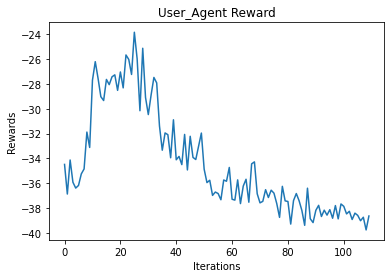

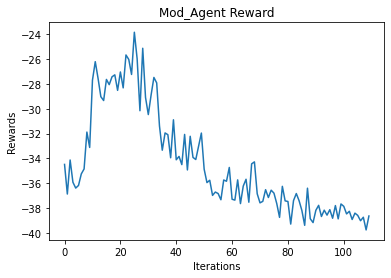

 22%|███████████████▉                                                        | 11101/50000 [1:01:01<4:57:08,  2.18it/s]

Updated Weights
Mean Reward = -38.82
5


 22%|████████████████▏                                                       | 11201/50000 [1:01:47<5:00:24,  2.15it/s]

Updated Weights
Mean Reward = -39.06
3


 23%|████████████████▎                                                       | 11302/50000 [1:02:33<3:58:33,  2.70it/s]

Updated Weights
Mean Reward = -38.28
7


 23%|████████████████▍                                                       | 11401/50000 [1:03:18<4:54:06,  2.19it/s]

Updated Weights
Mean Reward = -37.17
10


 23%|████████████████▌                                                       | 11500/50000 [1:04:05<4:58:02,  2.15it/s]

Updated Weights
Mean Reward = -39.45
2


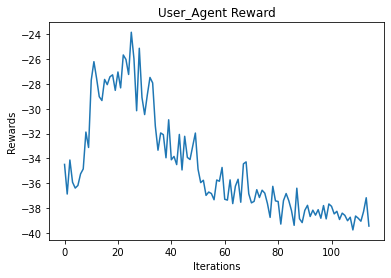

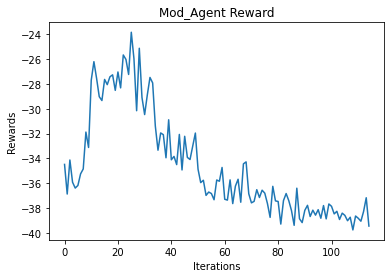

 23%|████████████████▋                                                       | 11601/50000 [1:04:52<5:03:29,  2.11it/s]

Updated Weights
Mean Reward = -39.15
3


 23%|████████████████▊                                                       | 11701/50000 [1:05:38<4:58:36,  2.14it/s]

Updated Weights
Mean Reward = -38.42
6


 24%|████████████████▉                                                       | 11801/50000 [1:06:25<4:50:40,  2.19it/s]

Updated Weights
Mean Reward = -39.97
1


 24%|█████████████████▏                                                      | 11901/50000 [1:07:12<5:01:21,  2.11it/s]

Updated Weights
Mean Reward = -39.55
2


 24%|█████████████████▎                                                      | 12000/50000 [1:07:59<5:17:57,  1.99it/s]

Updated Weights
Mean Reward = -39.89
1


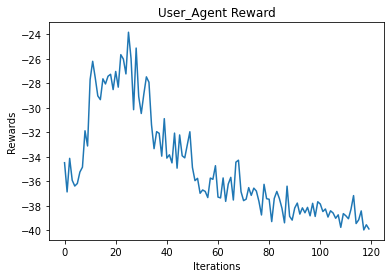

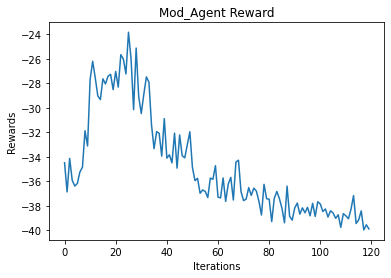

 24%|█████████████████▍                                                      | 12101/50000 [1:08:46<4:51:06,  2.17it/s]

Updated Weights
Mean Reward = -38.27
7


 24%|█████████████████▌                                                      | 12201/50000 [1:09:34<5:11:02,  2.03it/s]

Updated Weights
Mean Reward = -38.64
5


 25%|█████████████████▋                                                      | 12301/50000 [1:10:20<5:11:53,  2.01it/s]

Updated Weights
Mean Reward = -38.36
7


 25%|█████████████████▊                                                      | 12401/50000 [1:11:08<4:47:16,  2.18it/s]

Updated Weights
Mean Reward = -38.96
3


 25%|██████████████████                                                      | 12500/50000 [1:11:55<4:54:18,  2.12it/s]

Updated Weights
Mean Reward = -38.6
6


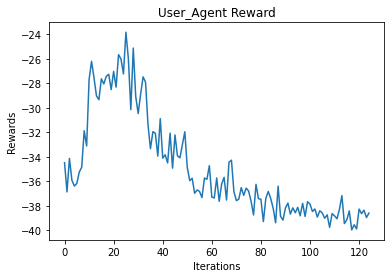

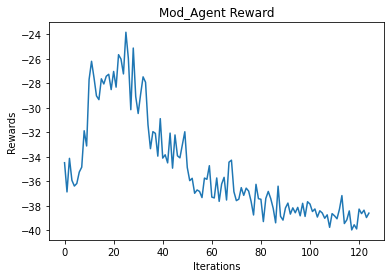

 25%|██████████████████▏                                                     | 12601/50000 [1:12:44<5:20:45,  1.94it/s]

Updated Weights
Mean Reward = -39.29
2


 25%|██████████████████▎                                                     | 12701/50000 [1:13:33<4:51:04,  2.14it/s]

Updated Weights
Mean Reward = -39.93
1


 26%|██████████████████▍                                                     | 12801/50000 [1:14:21<5:12:40,  1.98it/s]

Updated Weights
Mean Reward = -39.21
2


 26%|██████████████████▌                                                     | 12901/50000 [1:15:08<4:29:23,  2.30it/s]

Updated Weights
Mean Reward = -38.69
4


 26%|██████████████████▋                                                     | 13000/50000 [1:15:54<4:57:55,  2.07it/s]

Updated Weights
Mean Reward = -38.21
5


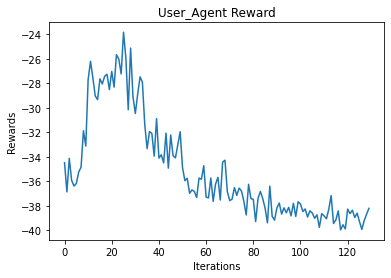

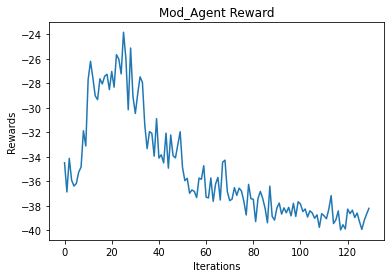

 26%|██████████████████▊                                                     | 13101/50000 [1:16:43<4:46:51,  2.14it/s]

Updated Weights
Mean Reward = -39.08
4


 26%|███████████████████                                                     | 13201/50000 [1:17:31<5:09:07,  1.98it/s]

Updated Weights
Mean Reward = -38.05
6


 27%|███████████████████▏                                                    | 13301/50000 [1:18:18<4:03:22,  2.51it/s]

Updated Weights
Mean Reward = -38.08
8


 27%|███████████████████▎                                                    | 13401/50000 [1:19:08<5:05:53,  1.99it/s]

Updated Weights
Mean Reward = -39.63
2


 27%|███████████████████▍                                                    | 13500/50000 [1:19:55<4:01:43,  2.52it/s]

Updated Weights
Mean Reward = -37.31
8


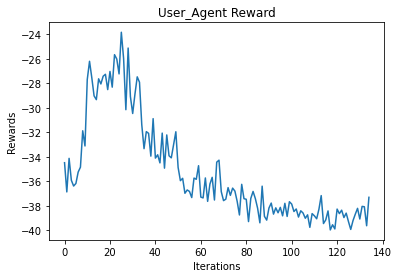

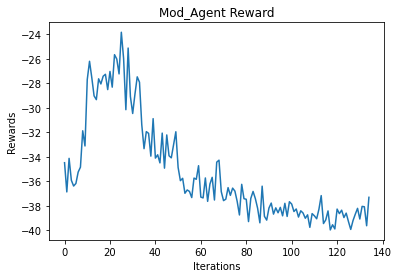

 27%|███████████████████▌                                                    | 13601/50000 [1:20:45<5:00:09,  2.02it/s]

Updated Weights
Mean Reward = -39.73
2


 27%|███████████████████▋                                                    | 13701/50000 [1:21:33<4:56:37,  2.04it/s]

Updated Weights
Mean Reward = -39.41
2


 28%|███████████████████▊                                                    | 13801/50000 [1:22:23<5:07:36,  1.96it/s]

Updated Weights
Mean Reward = -39.14
3


 28%|████████████████████                                                    | 13901/50000 [1:23:11<4:52:57,  2.05it/s]

Updated Weights
Mean Reward = -38.92
3


 28%|████████████████████▏                                                   | 13995/50000 [1:24:01<3:36:11,  2.78it/s]


KeyboardInterrupt: 

In [5]:
# user_agent.model.load_weights('user_agent.h5')
rewards = []
mean_rewards = []
max_steps = 40
reached = 0
max_reached = 0
mod_rewards = []
mean_mod_rewards = []
for epoch in tqdm(range(50000)):
    done = False
    episode_reward = 0
    episode_reward_mod = 0
    step = 0
    start, dest = env.give_start_dest()
    state = [start[0], start[1], dest[0], dest[1]]
    mod_state = []    #deque(maxlen = prev_timesteps)
    while not done and step<max_steps:
        state = np.array(state)
        next_state, reward, done, mod_reward = user_agent.play_one_step(env, state, mod_agent, mod_state)
        state = next_state
        episode_reward+=reward
        episode_reward_mod+=mod_reward
        step+=1
        if done:
            reached+=1
            
    if epoch>50:
        user_agent.train()
        mod_agent.train()
    
    if epoch>50 and epoch%100==0:
        user_agent.target_model.set_weights(user_agent.model.get_weights())
        mod_agent.target_model.set_weights(mod_agent.model.get_weights())
        print('Updated Weights')
        
    if epoch>50 and epoch%1000==0:
        mod_agent.epsilon*=0.9
        user_agent.epsilon*=0.9

    mean_rewards.append(episode_reward)
    mean_mod_rewards.append(episode_reward_mod)
    
    if epoch%100==0 and epoch:
        rewards.append(np.mean(mean_rewards))
        mod_rewards.append(np.mean(mean_mod_rewards))
        mean_rewards = []
        mean_mod_rewards = []
        print(f'Mean Reward = {rewards[-1]}')
        print(reached)
        
        if reached>max_reached:
            print('Saved Weights')
            max_reached = reached
            user_agent.model.save(f'models\\user_agent_{epoch}.h5')
            mod_agent.model.save(f'models\\mod_agent_{epoch}.h5')
        reached = 0
        
    if epoch%500==0 and epoch:
        plt.plot(rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.title('User_Agent Reward')
        plt.show()
        
        plt.plot(mod_rewards)
        plt.xlabel('Iterations')
        plt.ylabel('Rewards')
        plt.title('Mod_Agent Reward')
        plt.show()
    

In [ ]:
# user_agent.model = tf.keras.models.load_model(r'models\user_agent_40800.h5')
# mod_agent.model = tf.keras.models.load_model(r'models\mod_agent_40800.h5')

In [ ]:
user_agent.epsilon = 0
mod_agent.epsilon = 0
done = False
episode_reward = 0
episode_reward_mod = 0
step = 0
start, dest = env.give_start_dest()
state = [start[0], start[1], dest[0], dest[1]]
max_steps = 40
mod_state = []
while not done and step<max_steps:
    state = np.array(state)
    print(state)
#     print(mod_state)
    print(episode_reward)
    print(episode_reward_mod)
    next_state, reward, done, reward_mod = user_agent.play_one_step(env, state, mod_agent, mod_state)
    state = next_state
    episode_reward+=reward
    episode_reward_mod+=reward_mod
    step+=1
    if done:
        reached+=1
        
print(episode_reward)
print(done)

In [ ]:
print(done)

In [ ]:
next_states = np.array([mod_agent.replay_buffer.state_history[i] for i in [0,120]])
print(next_states.shape)

In [ ]:
print(next_states)

In [ ]:
max(mod_agent.replay_buffer.action_history)

In [ ]:
user_agent.model.save('user_agent.h5')
mod_agent.model.save('mod_agent.h5')